# Gradient Visualization for Radial 1D Stellar Wind Simulation

## Imports

In [1]:
# numerics
import jax
import jax.numpy as jnp
from jax import grad
# 64-bit precision
jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_debug_nans", True)

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# fluids
from jf1uids import OPEN_BOUNDARY, REFLECTIVE_BOUNDARY, SPHERICAL
from jf1uids import SimulationConfig
from jf1uids import get_helper_data
from jf1uids import SimulationParams
from jf1uids import time_integration
from jf1uids import primitive_state

## Initiating the stellar wind simulation

In [2]:
print("👷 Setting up simulation...")

# simulation settings
gamma = 5/3

# spatial domain
alpha = SPHERICAL
box_size = 1.0
num_cells = 101
dx = box_size / (num_cells - 1)

fixed_timestep = False

intermediate_saves = True
num_saves = 40

# introduce constants to 
# make this more readable
left_boundary = REFLECTIVE_BOUNDARY
right_boundary = OPEN_BOUNDARY

# activate stellar wind
stellar_wind = False

# setup simulation config
config = SimulationConfig(
    alpha_geom = alpha,
    box_size = box_size, 
    num_cells = num_cells,
    dx = dx,
    left_boundary = left_boundary, 
    right_boundary = right_boundary, 
    stellar_wind = stellar_wind,
    fixed_timestep = fixed_timestep,
    intermediate_saves = intermediate_saves,
    num_saves = num_saves
)

helper_data = get_helper_data(config)

👷 Setting up simulation...


2024-09-17 10:49:38.123111: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Setting the simulation parameters and initial state

In [3]:
# time domain
dt_max = 0.1
C_CFL = 0.8
t_end = 0.2

# SOD shock tube
shock_pos = 0.5

r = helper_data.geometric_centers

rho = jnp.where(r < shock_pos, 1.0, 0.125)
u = jnp.zeros_like(r)
p = jnp.where(r < shock_pos, 1.0, 0.1)

# get initial state
initial_state = primitive_state(rho, u, p)

params = SimulationParams(C_cfl = C_CFL, dt_max = dt_max, gamma = gamma, t_end = t_end)

## Conservation test of the simulation

In [4]:
def init_shock_problem(num_cells, config, params, first_order_fallback = False):
    config = config._replace(num_cells = num_cells, dx = config.box_size / (num_cells - 1), first_order_fallback = first_order_fallback)
    params = params._replace(dt_max = dt_max)
    helper_data = get_helper_data(config)
    r = helper_data.geometric_centers
    rho = jnp.where(r < shock_pos, 1.0, 0.125)
    u = jnp.zeros_like(r)
    p = jnp.where(r < shock_pos, 1.0, 0.1)

    # get initial state
    initial_state = primitive_state(rho, u, p)
    return initial_state, config, params, helper_data

initial_state_shock100, config_shock100, params_shock100, helper_data_shock100 = init_shock_problem(101, config, params)
checkpoints_shock100 = time_integration(initial_state_shock100, config_shock100, params_shock100, helper_data_shock100)

initial_state_shock100_first_order, config_shock100_first_order, params_shock100_first_order, helper_data_shock100_first_order = init_shock_problem(101, config, params, True)
checkpoints_shock100_first_order = time_integration(initial_state_shock100_first_order, config_shock100_first_order, params_shock100_first_order, helper_data_shock100_first_order)

initial_state_shock, config_shock, params_shock, helper_data_shock = init_shock_problem(2001, config, params, True)
checkpoints_shock2000 = time_integration(initial_state_shock, config_shock, params_shock, helper_data_shock)

### Visualization of the mass and energy development

0.2099697389639914
0.08317066892050207


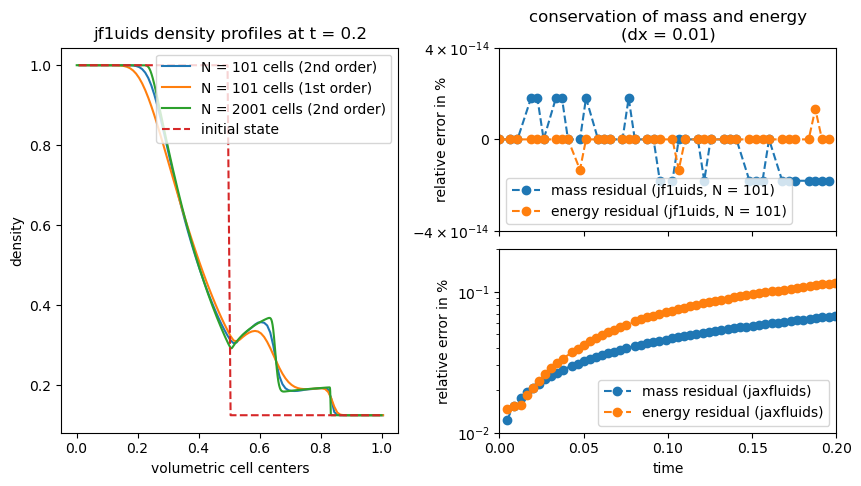

In [5]:
relative_mass_error = (checkpoints_shock100.total_mass_proxy - checkpoints_shock100.total_mass_proxy[0]) / checkpoints_shock100.total_mass_proxy[0] * 100
relative_energy_error = (checkpoints_shock100.total_energy_proxy - checkpoints_shock100.total_energy_proxy[0]) / checkpoints_shock100.total_energy_proxy[0] * 100

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(2, 2, figure=fig)

gs.update(wspace=0.3, hspace=0.1)

ax1 = fig.add_subplot(gs[:, 0])  # Left plot spanning both rows
ax2 = fig.add_subplot(gs[0, 1])  # Top-right plot
ax3 = fig.add_subplot(gs[1, 1])  # Bottom-right plot

ax2.plot(checkpoints_shock100.times, relative_mass_error, "o--", label="mass residual (jf1uids, N = 101)")

ax3.set_xlabel("time")
ax2.legend(loc = "upper left")

ax2.set_ylabel("relative error in %")

ax2.yaxis.set_label_coords(-0.15, 0.5)

ax2.plot(checkpoints_shock100.times, relative_energy_error, "o--", label="energy residual (jf1uids, N = 101)")

ax2.legend(loc = "lower left")
ax2.set_title("conservation of mass and energy\n(dx = 0.01)")
ax2.set_xticklabels([])
ax2.set_xlim(0, 0.2)
ax3.set_xlim(0, 0.2)

# less x ticks
ax3.set_xticks([0.0, 0.05, 0.1, 0.15, 0.2])
ax2.set_xticks([0.0, 0.05, 0.1, 0.15, 0.2])

sod_error = jnp.load("data/sod_errors.npy")
times_jaxfluids, mass_errors_jaxfluids, energy_errors_jaxfluids = sod_error
ax3.plot(times_jaxfluids, mass_errors_jaxfluids, "o--", label="mass residual (jaxfluids)")
ax3.plot(times_jaxfluids, energy_errors_jaxfluids, "o--", label="energy residual (jaxfluids)")
ax3.set_ylim(1e-2, 0.2)

ax3.set_ylabel("relative error in %")

ax3.tick_params(axis='y')

ax3.set_yscale("log")
ax2.set_yscale("symlog")
ax2.set_ylim(-4e-14, 4e-14)

ax3.legend(loc = "lower right")

ax1.plot(helper_data_shock100.volumetric_centers, checkpoints_shock100.states[-1,0,:], label="N = 101 cells (2nd order)")
ax1.plot(helper_data_shock100_first_order.volumetric_centers, checkpoints_shock100_first_order.states[-1,0,:], label="N = 101 cells (1st order)")
ax1.plot(helper_data_shock.volumetric_centers, checkpoints_shock2000.states[-1,0,:], label="N = 2001 cells (2nd order)")

ax1.set_title("jf1uids density profiles at t = 0.2")

# also plot the initial state in -- for reference
ax1.plot(helper_data_shock100.volumetric_centers, initial_state_shock100[0], "--", label="initial state")

ax1.set_xlabel("volumetric cell centers")
ax1.set_ylabel("density")

ax1.legend(loc = "upper right")

print(checkpoints_shock100.runtime)
print(checkpoints_shock2000.runtime)

plt.savefig("figures/conservational_properties.png")